In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
# from spacy_language_detection import LanguageDetector
from scipy.stats import chi2_contingency
from scipy import stats

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [4]:
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

/var/folders/l6/xlxb5g75383frbl9qkkpxhxh0000gn/T/ipykernel_2218/3223522512.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


# Seeing the world through the lens of beer reviews


Beers are produced and consumed in every part of the world. One can thus wonder how beers around the world are perceived by different cultures. The interest of this project is to look into how beers from each country of production are judged and how specific countries judge others. As a side note, we will finally answer an age-old question : Are German beers actually good ?

On the one hand, we want to explore how a country’s beers are perceived both quantitatively and qualitatively. On the other hand, we will analyze the users’ ratings and look for significant patterns in how distinct countries rate other countries. For both of these analyses, we will dissect both the ratings and reviews to understand the feelings of the users. These findings will also be mapped to their climate to see if there is a correlation between a countries’ beer rating and the climate of said country. 


In [5]:
# For the analysis, drop NaN from the columns of interest
us_users_ratings = us_users_ratings.dropna(subset=["overall", "abv"])

## Plot on a US map 

In [404]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import geopandas as gpd
import pandas as pd

def plot_climate_stats(df, column, title, column_ticks=None, cmap_name = "YlOrRd"): #RdBu_r
    """
    This function plots on a map of the United States the mean of the column passed as an argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        ax (matplotlib.axes.Axes, optional): Axes on which to plot. If None, a new figure and axes are created.
        symmetrical (bool, optional): If True, the colorbar is symmetrical around 0. If False, the colorbar is not symmetrical around 0.
        categorical (bool, optional): If True, the column is categorical. If False, the column is numerical.
    """
    
    us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")
    
    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii
    
    
    fig, ax = plt.subplots(figsize=(8, 7))
    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")

    # Plot on the colorbar only the unique values associated to the each climate type
    values = df[column].unique()
    # Sort the dictionary by descending values
    norm = Normalize(vmin=values.min(), vmax=values.max())
    sm = cm.ScalarMappable(cmap=cmap_name, norm=norm)
    sm.set_array([])  


    us_map_shifted.plot(column=column, cmap=cmap_name, ax=ax, legend=False, missing_kwds={"color": "lightgrey", "label": "Missing values"})

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=values)
    cbar.set_ticks(values)

    ticks_labels_dict = zip(values, df[column_ticks].unique())

    cbar.set_ticklabels([label + ": {:.2f}".format(value) for value, label in ticks_labels_dict])
    ax.set_title(title)
    #change the size of the title
    ax.title.set_size(13) 
    ax.set_axis_off()
    ax.set_xlim(-140, -60)

    
    plt.show()


## Add the column *General Style*

In [88]:
# reimport edited file with the corresponding beer types
mapping_df = pd.DataFrame(pd.read_excel("beer_style_edited.xlsx"))
print(
    "There are {} different general beer types".format(
        len(set(mapping_df["general_style"]))
    )
)

# extract all general beer types
general_beer_types = list(set(mapping_df["general_style"]))
print(general_beer_types)

# add a column to the us_users_ratings dataframe with the corresponding general beer type
us_users_ratings = pd.merge(us_users_ratings, mapping_df, on="style", how="left")
us_users_ratings.head()

There are 10 different general beer types
['Sour Ale', 'Blonde Ale', 'Porter', 'Wheat beer', 'Pale Ale', 'Lager', 'Brown Ale', 'Stout', 'IPA', 'Scottish Ale ']


,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style_x,general_style_y,general_style
0,19827,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,...,North Carolina,264.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale,Pale Ale,Pale Ale
1,19827,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,...,New York,2314.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale,Pale Ale,Pale Ale
2,19827,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,...,Illinois,585.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale,Pale Ale,Pale Ale
3,19827,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,...,Massachusetts,1315.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale,Pale Ale,Pale Ale
4,19827,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,...,North Carolina,6306.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale,Pale Ale,Pale Ale


## 3) First analysis : Correlation between climate and abv

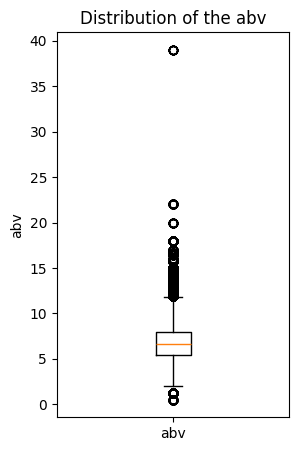

In [89]:
# boxplot of abv of the us
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_users_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

5th percentile: 4.5
95th percentile: 11.0
Shape before filtering: (862743, 38)
Shape after filtering: (783427, 38)


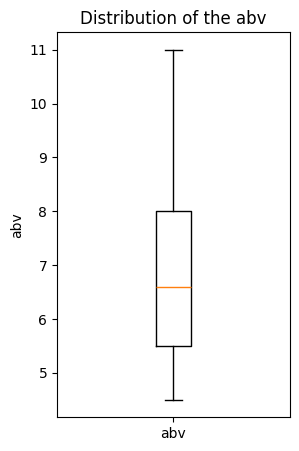

In [90]:
# keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("5th percentile:", quantile_5)
print("95th percentile:", quantile_95)

print("Shape before filtering:", us_users_ratings.shape)
us_abv_ratings = us_users_ratings[
    (us_users_ratings["abv"] >= quantile_5) & (us_users_ratings["abv"] <= quantile_95)
]
print("Shape after filtering:", us_abv_ratings.shape)

# Boxplot of the abv of us_abv_ratings
fig, ax = plt.subplots(figsize=(3, 5))
ax.boxplot(us_abv_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

In [91]:
# sort a dataframe with the name ot the climate
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])

# to store the climate dataframes
climate_dataframes = {}

# create a for loop to create separate dataframes for each climate based on the climate_names
for climate in climate_names["climate"]:
    climate_df = pd.DataFrame(
        us_abv_ratings[us_abv_ratings["climate"] == climate].reset_index(drop=True)
    )
    climate_dataframes[climate] = climate_df.sort_values(
        by="overall", ascending=False
    ).reset_index(drop=True)

In [92]:
us_abv_means = pd.DataFrame(
    columns=["climate", "mean_abv_overall", "mean_abv_best", "mean_abv_most"]
)



for climate in climate_names["climate"]:
    climate_df = us_abv_ratings[us_abv_ratings["climate"] == climate]


    # Compute the mean abv for each climate weighted by overall score

    mean_abv_overall = (climate_df["abv"] * climate_df["overall"]).sum() / climate_df[
        "overall"
    ].sum()


    us_abv_means.loc[len(us_abv_means)] = [climate, mean_abv_overall, 0.0, 0.0]



display(us_abv_means)

,climate,mean_abv_overall,mean_abv_best,mean_abv_most
0,Cfa,6.910911,0.0,0.0
1,Dfa,6.965748,0.0,0.0
2,Cfb,6.758007,0.0,0.0
3,Dfb,6.896353,0.0,0.0
4,Dfc,6.867785,0.0,0.0
5,Dsc,6.795549,0.0,0.0
6,Dsb,6.870914,0.0,0.0
7,Csa,6.990549,0.0,0.0
8,Csb,6.855522,0.0,0.0
9,Bsk,6.849988,0.0,0.0


In [93]:
keeping_best_beers = {}
count_style_occurences = {}

# create new dataframes containign the best three beers for each climate
for climate, climate_df in climate_dataframes.items():
    us_grouped_beers = climate_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # count the number of occurences of each style of beer
    for beer in best_three.index:
        if beer not in count_style_occurences.keys():
            count_style_occurences[beer] = 1
        else:
            count_style_occurences[beer] += 1

    keeping_best_beers[climate] = climate_df[
        climate_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)

print("Number of times a beer style appears in the top 3 beers of a climate: ")
display(count_style_occurences)

Number of times a beer style appears in the top 3 beers of a climate: 


{'Sour Ale': 10, 'IPA': 10, 'Stout': 10}

In [94]:
for climate in keeping_best_beers:
    # calculate the mean of the abv in the column abv of the dataframe
    mean_abv_best = keeping_best_beers[climate]["abv"].mean()
    us_abv_means.loc[
        us_abv_means["climate"] == climate, "mean_abv_best"
    ] = mean_abv_best

display(us_abv_means)

,climate,mean_abv_overall,mean_abv_best,mean_abv_most
0,Cfa,6.910911,7.356880,0.0
1,Dfa,6.965748,7.459210,0.0
2,Cfb,6.758007,7.322380,0.0
3,Dfb,6.896353,7.336444,0.0
4,Dfc,6.867785,7.230568,0.0
5,Dsc,6.795549,7.220047,0.0
6,Dsb,6.870914,7.244643,0.0
7,Csa,6.990549,7.300237,0.0
8,Csb,6.855522,7.170656,0.0
9,Bsk,6.849988,7.268724,0.0


In [95]:
keeping_most_reviewed_beers = {}
count_style_occurences = {}

for climate, climate_df in climate_dataframes.items():
    # get number of occurences of each style of beer
    num_reviews = climate_df["general_style"].value_counts()

    # keep only the 3 most reviewed beers
    most_reviewed = num_reviews[:3]

    # count the number of occurences of each style of beer
    for beer in most_reviewed.index:
        if beer not in count_style_occurences.keys():
            count_style_occurences[beer] = 1
        else:
            count_style_occurences[beer] += 1

    keeping_most_reviewed_beers[climate] = climate_df[
        climate_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)

print("Most reviewed beers for each climate:")
for climate in keeping_most_reviewed_beers:
    print(
        "Climate {}: {}".format(
            climate, keeping_most_reviewed_beers[climate]["general_style"].unique()
        )
    )

print("Number of occurences of each style of beer:")
display(count_style_occurences)

Most reviewed beers for each climate:
Climate Cfa: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Dfa: ['Pale Ale' 'Brown Ale' 'IPA']
Climate Cfb: ['IPA' 'Pale Ale' 'Brown Ale']
Climate Dfb: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Dfc: ['IPA' 'Pale Ale' 'Brown Ale']
Climate Dsc: ['IPA' 'Brown Ale' 'Pale Ale']
Climate Dsb: ['IPA' 'Brown Ale' 'Pale Ale']
Climate Csa: ['IPA' 'Pale Ale' 'Brown Ale']
Climate Csb: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Bsk: ['IPA' 'Brown Ale' 'Pale Ale']
Number of occurences of each style of beer:


{'IPA': 10, 'Pale Ale': 10, 'Brown Ale': 10}

In [96]:
for climate in keeping_most_reviewed_beers:
    # calculate the mean of the abv in the column abv of the dataframe
    mean_abv_most = keeping_most_reviewed_beers[climate]["abv"].mean()
    us_abv_means.loc[
        us_abv_means["climate"] == climate, "mean_abv_most"
    ] = mean_abv_most

display(us_abv_means)

,climate,mean_abv_overall,mean_abv_best,mean_abv_most
0,Cfa,6.910911,7.356880,6.836905
1,Dfa,6.965748,7.459210,6.903023
2,Cfb,6.758007,7.322380,6.774415
3,Dfb,6.896353,7.336444,6.819313
4,Dfc,6.867785,7.230568,6.766260
5,Dsc,6.795549,7.220047,6.700405
6,Dsb,6.870914,7.244643,6.776383
7,Csa,6.990549,7.300237,6.944616
8,Csb,6.855522,7.170656,6.780525
9,Bsk,6.849988,7.268724,6.807197


/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


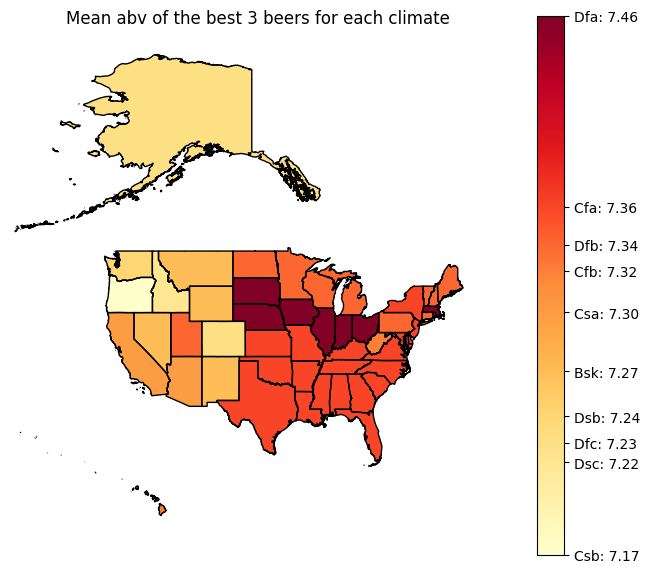

In [384]:
#plot the mean_abv_best for each climate
plot_climate_stats(us_abv_means, 
                   "mean_abv_best", 
                   "Mean abv of the best 3 beers for each climate", 
                   "climate")

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


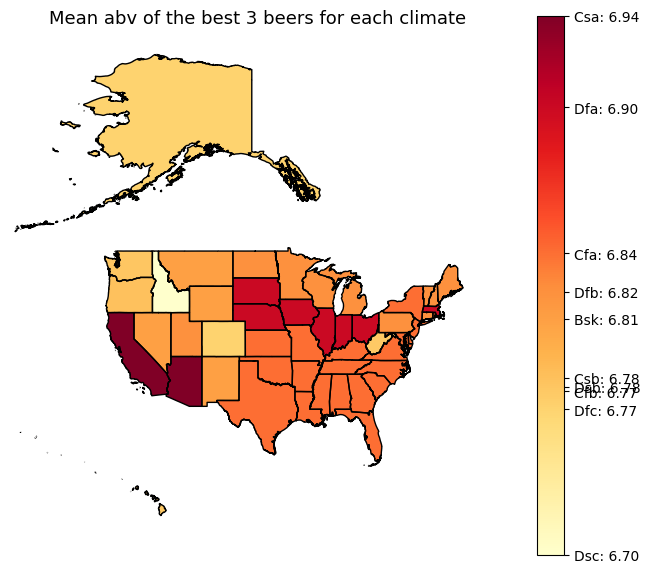

In [405]:
#plot the mean_abv_best for each climate
plot_climate_stats(us_abv_means, 
                   "mean_abv_most", 
                   "Mean abv of the best 3 beers for each climate", 
                   "climate")

In [97]:
# One-way ANOVA test for the mean abv of each climate
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate == zone]["abv"]
        for zone in us_abv_ratings.climate.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate
res = stats.f_oneway(
    *[keeping_best_beers[zone]["abv"] for zone in keeping_best_beers.keys()], axis=0
)
print("One-way ANOVA test for the mean abv of best beers of each climate:", res[1])

# One-way ANOVA test for the mean abv of most reviewed beers of each climate
res = stats.f_oneway(
    *[
        keeping_most_reviewed_beers[zone]["abv"]
        for zone in keeping_most_reviewed_beers.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate: 5.168135814480176e-101
One-way ANOVA test for the mean abv of best beers of each climate: 3.247824368429714e-121
One-way ANOVA test for the mean abv of most reviewed beers of each climate: 1.7894967358885408e-114


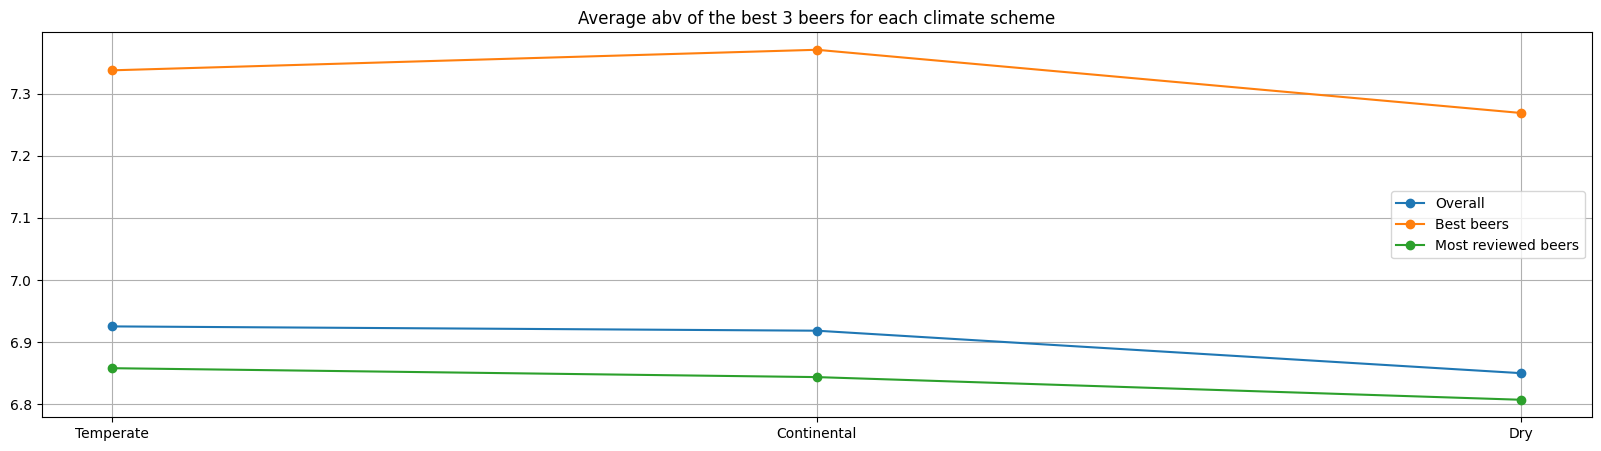

In [361]:
# Now test the climate scheme
mean_abv_overall = {}
best_beers_scheme_dfs = {}
best_beers_scheme_abv = {}
most_reviewed_scheme_dfs = {}
most_reviewed_scheme_abv = {}

for climate_s in us_users_ratings["climate_scheme"].unique():
    climate_scheme_df = us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_s]

    mean_abv_overall[climate_s] = (
        climate_scheme_df["abv"] * climate_scheme_df["overall"]
    ).sum() / climate_scheme_df["overall"].sum()

    us_grouped_beers = climate_scheme_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_scheme_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_scheme_dfs[climate_s] = climate_scheme_df[
        climate_scheme_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
    best_beers_scheme_abv[climate_s] = best_beers_scheme_dfs[climate_s]["abv"].mean()

    most_reviewed_scheme_dfs[climate_s] = climate_scheme_df[
        climate_scheme_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
    most_reviewed_scheme_abv[climate_s] = most_reviewed_scheme_dfs[climate_s][
        "abv"
    ].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_overall[climate_s]
        for climate_s in us_users_ratings["climate_scheme"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_scheme_abv[climate_s]
        for climate_s in us_users_ratings["climate_scheme"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_scheme_abv[climate_s]
        for climate_s in us_users_ratings["climate_scheme"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings["climate_scheme"].unique())),
    us_users_ratings["climate_scheme"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate scheme")
ax.grid()
ax.legend()
plt.show()

In [362]:
#load the df with the climate classified
climate_classified = pd.read_csv("data/climate_classified.csv")

# create a df with all the cliate in a column, 
#in the second the corresponding climate scheme a
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])
climate_names["climate_scheme"] = climate_names["climate"].map(
    climate_classified.set_index("climate")["scheme"]
)
#in the third the average abv of the best 3 beers for each climate scheme
climate_names["abv_mean"] = climate_names["climate_scheme"].map(
    best_beers_scheme_abv
)

#in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names["abv_mean_most_reviewd"] = climate_names["climate_scheme"].map(
    most_reviewed_scheme_abv
)

#in the fifth the average abv of all the beers for each climate scheme
climate_names["abv_mean_overall"] = climate_names["climate_scheme"].map(
    mean_abv_overall
)
climate_names.head(10)

,climate,climate_scheme,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,Temperate,7.337447,6.858030,6.925281
1,Dfa,Continental,7.370499,6.843697,6.918382
2,Cfb,Temperate,7.337447,6.858030,6.925281
3,Dfb,Continental,7.370499,6.843697,6.918382
4,Dfc,Continental,7.370499,6.843697,6.918382
5,Dsc,Continental,7.370499,6.843697,6.918382
6,Dsb,Continental,7.370499,6.843697,6.918382
7,Csa,Temperate,7.337447,6.858030,6.925281
8,Csb,Temperate,7.337447,6.858030,6.925281
9,Bsk,Dry,7.268724,6.807197,6.849988


/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


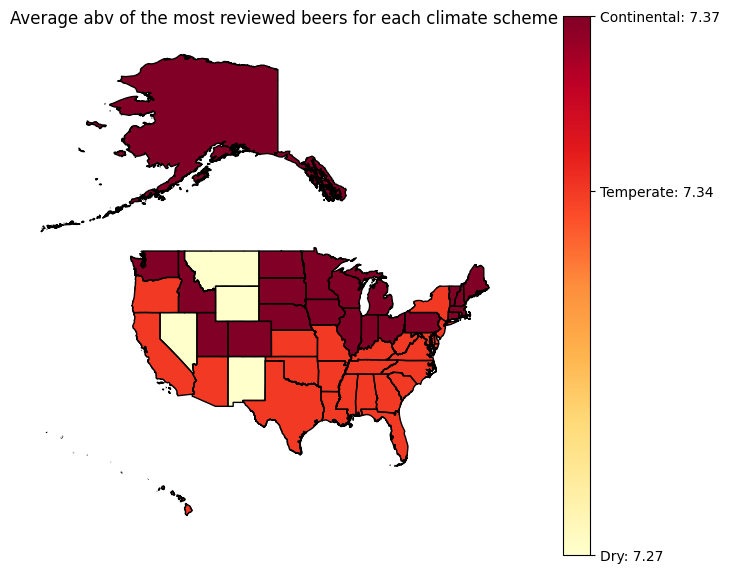

In [363]:
plot_climate_stats(
    climate_names,
    "abv_mean",
    "Average abv of the most reviewed beers for each climate scheme",
    "climate_scheme",
)

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


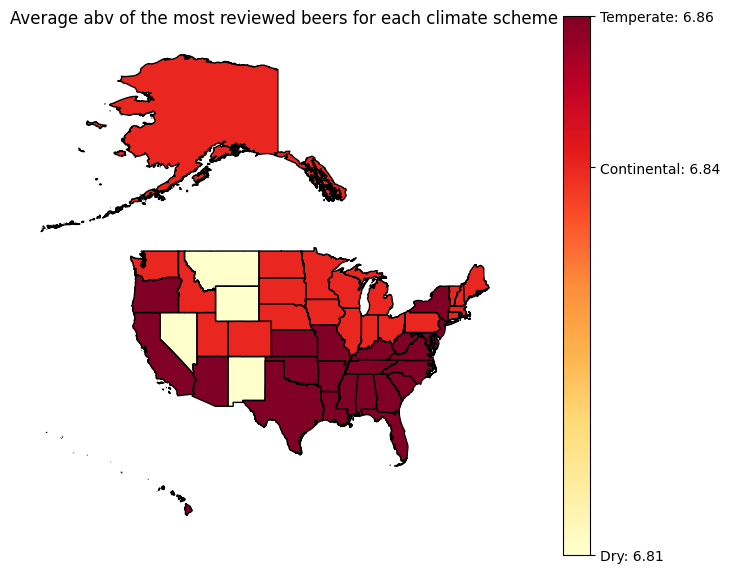

In [364]:
plot_climate_stats(
    climate_names,
    "abv_mean_most_reviewd",
    "Average abv of the most reviewed beers for each climate scheme",
    "climate_scheme",
)

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


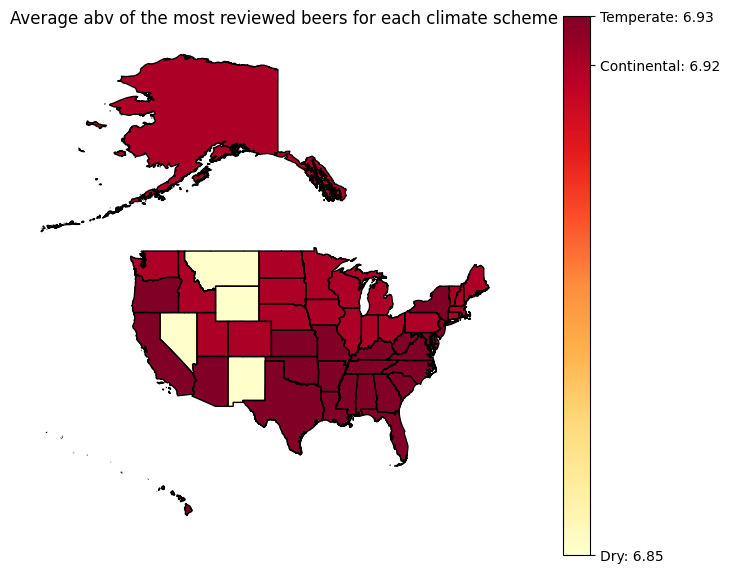

In [365]:
plot_climate_stats(
    climate_names,
    "abv_mean_overall",
    "Average abv of the most reviewed beers for each climate scheme",
    "climate_scheme",
)

In [366]:
# One-way ANOVA test for the mean abv of each climate scheme
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_scheme == zone]["abv"]
        for zone in us_abv_ratings.climate_scheme.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate scheme:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate scheme
res = stats.f_oneway(
    *[best_beers_scheme_dfs[zone]["abv"] for zone in best_beers_scheme_dfs.keys()],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1]
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate scheme
res = stats.f_oneway(
    *[
        most_reviewed_scheme_dfs[zone]["abv"]
        for zone in most_reviewed_scheme_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate scheme:", res[1]
)

One-way ANOVA test for the mean abv of each climate scheme: 1.4982658694334239e-06
One-way ANOVA test for the mean abv of best beers of each climate scheme: 2.1477906266220373e-11
One-way ANOVA test for the mean abv of best beers of each climate scheme: 0.00031254912410991274


Overall average of best beers for climate without dry season: 3.981228746091151
Overall average of most reviewed beers for climate without dry season: 3.8670259238566245
Overall average of best beers for climate with dry season: 3.9844210078923337
Overall average of most reviewed beers for climate with dry season: 3.87191618588856


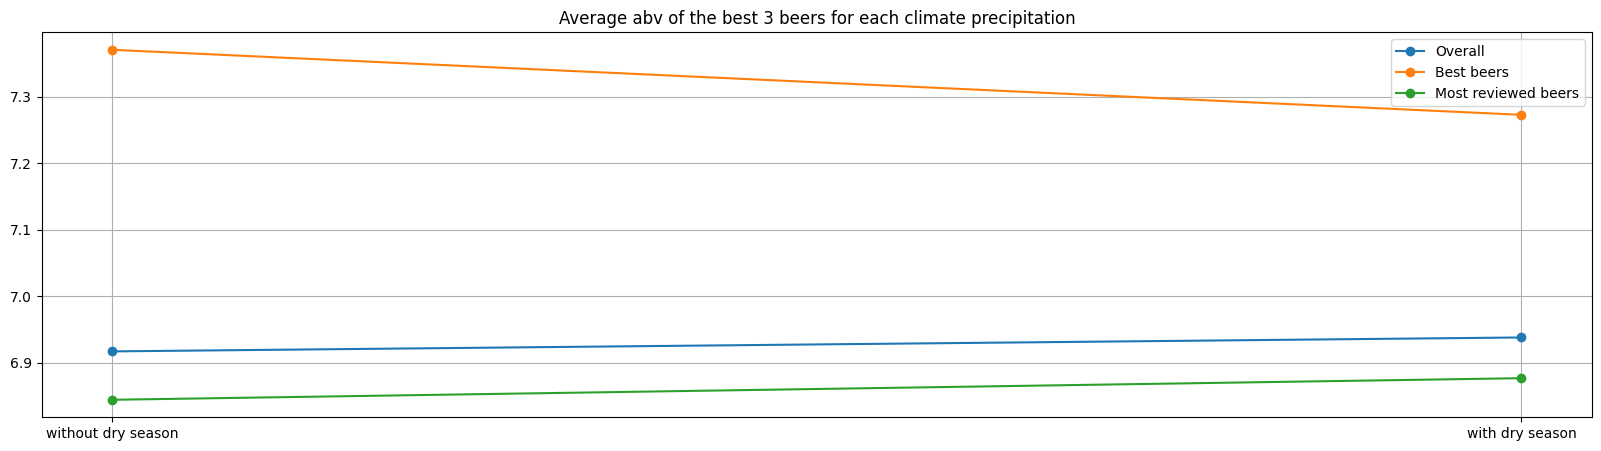

In [367]:
# Now test the climate precipitation, as there are multiple values, let's check their abv differences globally first
mean_abv_overall = {}
best_beers_precipitation_dfs = {}
best_beers_precipitation_abv = {}
most_reviewed_precipitation_dfs = {}
most_reviewed_precipitation_abv = {}

for climate_p in us_users_ratings["climate_precipitation"].unique():
    climate_precipitation_df = us_abv_ratings[
        us_abv_ratings["climate_precipitation"] == climate_p
    ]

    mean_abv_overall[climate_p] = (
        climate_precipitation_df["abv"] * climate_precipitation_df["overall"]
    ).sum() / climate_precipitation_df["overall"].sum()

    us_grouped_beers = climate_precipitation_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_precipitation_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_precipitation_dfs[climate_p] = climate_precipitation_df[
        climate_precipitation_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)

    print(
        "Overall average of best beers for climate {}: {}".format(
            climate_p, best_beers_precipitation_dfs[climate_p]["overall"].mean()
        )
    )

    best_beers_precipitation_abv[climate_p] = best_beers_precipitation_dfs[climate_p][
        "abv"
    ].mean()

    most_reviewed_precipitation_dfs[climate_p] = climate_precipitation_df[
        climate_precipitation_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)

    print(
        "Overall average of most reviewed beers for climate {}: {}".format(
            climate_p, most_reviewed_precipitation_dfs[climate_p]["overall"].mean()
        )
    )

    most_reviewed_precipitation_abv[climate_p] = most_reviewed_precipitation_dfs[
        climate_p
    ]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_overall[climate_p]
        for climate_p in us_users_ratings["climate_precipitation"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_precipitation_abv[climate_p]
        for climate_p in us_users_ratings["climate_precipitation"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_precipitation_abv[climate_p]
        for climate_p in us_users_ratings["climate_precipitation"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings["climate_precipitation"].unique())),
    us_users_ratings["climate_precipitation"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate precipitation")
ax.grid()
ax.legend()
plt.show()

In [369]:
#load the df with the climate classified
climate_classified = pd.read_csv("data/climate_classified.csv")

# create a df with all the cliate in a column, 
#in the second the corresponding climate precipitation a
climate_names_precipitation = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])
climate_names_precipitation["climate_precipitation"] = climate_names_precipitation["climate"].map(
    climate_classified.set_index("climate")["seasonal_precipitation"]
)
#in the third the average abv of the best 3 beers for each climate scheme
climate_names_precipitation["abv_mean"] = climate_names_precipitation["climate_precipitation"].map(
    best_beers_precipitation_abv
)

#in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names_precipitation["abv_mean_most_reviewd"] = climate_names_precipitation["climate_precipitation"].map(
    most_reviewed_precipitation_abv
)

#in the fifth the average abv of all the beers for each climate scheme
climate_names_precipitation["abv_mean_overall"] = climate_names_precipitation["climate_precipitation"].map(
    mean_abv_overall
)

climate_names_precipitation.head(10)

,climate,climate_precipitation,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,without dry season,7.370849,6.844568,6.917327
1,Dfa,without dry season,7.370849,6.844568,6.917327
2,Cfb,without dry season,7.370849,6.844568,6.917327
3,Dfb,without dry season,7.370849,6.844568,6.917327
4,Dfc,without dry season,7.370849,6.844568,6.917327
5,Dsc,with dry season,7.273038,6.877023,6.938266
6,Dsb,with dry season,7.273038,6.877023,6.938266
7,Csa,with dry season,7.273038,6.877023,6.938266
8,Csb,with dry season,7.273038,6.877023,6.938266
9,Bsk,with dry season,7.273038,6.877023,6.938266


/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


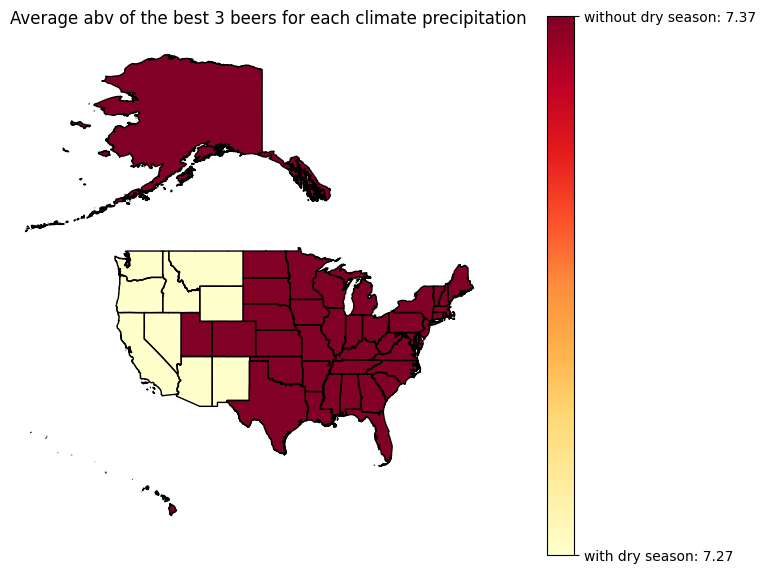

In [370]:
#plot the average abv of the best 3 beers for each climate precipitation
plot_climate_stats(
    climate_names_precipitation,
    "abv_mean",
    "Average abv of the best 3 beers for each climate precipitation",
    "climate_precipitation",
)

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


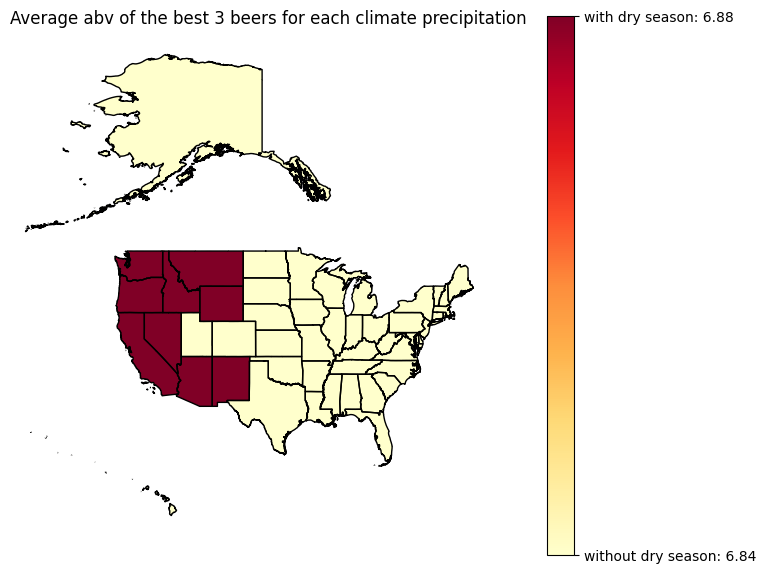

In [371]:
#plot the average abv of the best 3 beers for each climate precipitation
plot_climate_stats(
    climate_names_precipitation,
    "abv_mean_most_reviewd",
    "Average abv of the best 3 beers for each climate precipitation",
    "climate_precipitation",
)

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


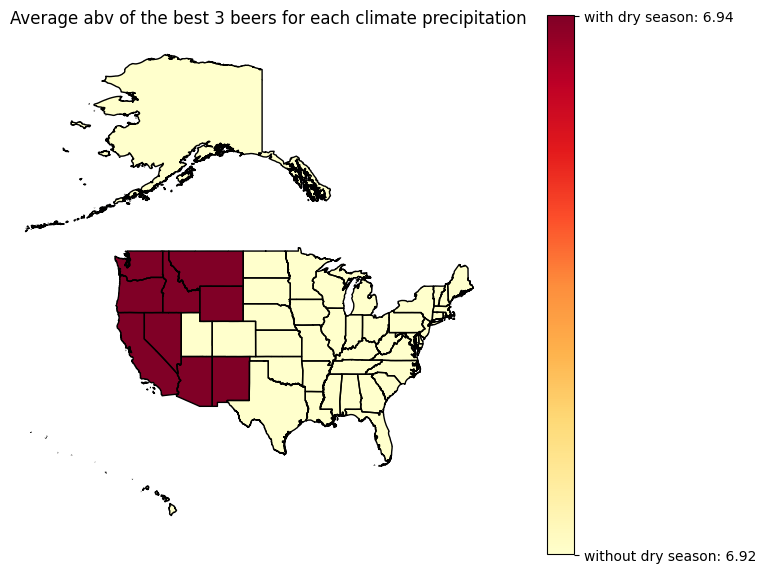

In [372]:
#plot the average abv of the best 3 beers for each climate precipitation
plot_climate_stats(
    climate_names_precipitation,
    "abv_mean_overall",
    "Average abv of the best 3 beers for each climate precipitation",
    "climate_precipitation",
)

In [373]:
# One-way ANOVA test for the mean abv of each climate precipitation
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_precipitation == zone]["abv"]
        for zone in us_abv_ratings.climate_precipitation.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate precipitation:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate precipitation
res = stats.f_oneway(
    *[
        best_beers_precipitation_dfs[zone]["abv"]
        for zone in best_beers_precipitation_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate precipitation:",
    res[1],
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation
res = stats.f_oneway(
    *[
        most_reviewed_precipitation_dfs[zone]["abv"]
        for zone in most_reviewed_precipitation_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate precipitation: 5.08100276710351e-08
One-way ANOVA test for the mean abv of best beers of each climate precipitation: 3.001034176773221e-46
One-way ANOVA test for the mean abv of most reviewed beers of each climate precipitation: 2.716777093164039e-09


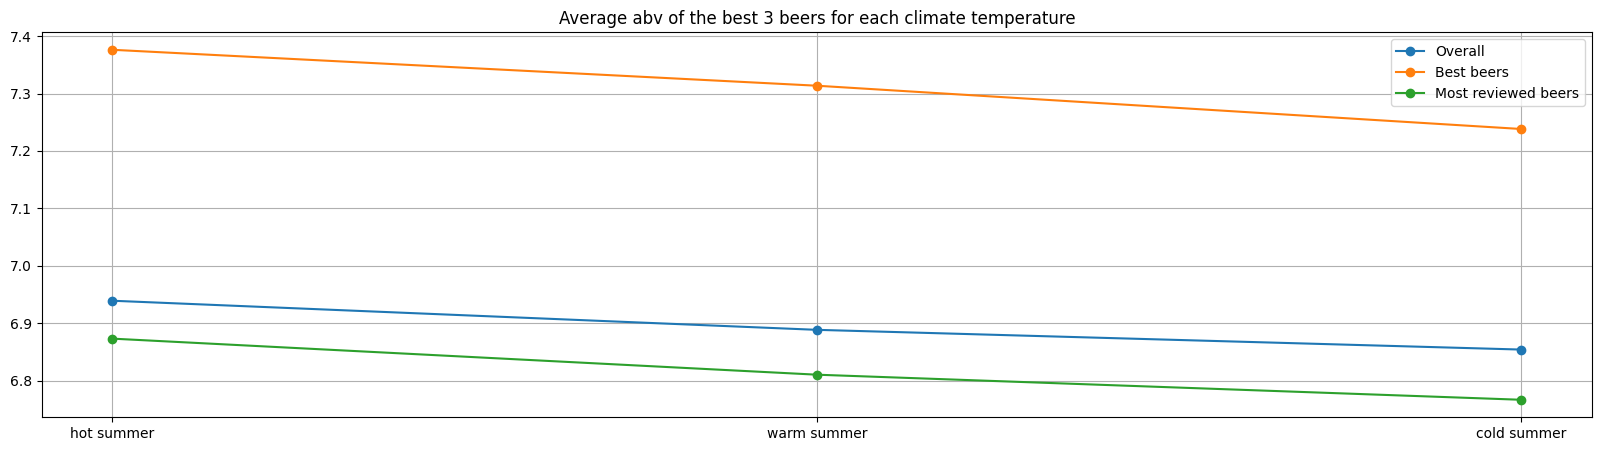

In [374]:
# Now test the climate temperature, as there are multiple values, let's check their abv differences globally first
mean_abv_overall = {}
best_beers_temperature_dfs = {}
best_beers_temperature_abv = {}
most_reviewed_temperature_dfs = {}
most_reviewed_temperature_abv = {}

for climate_t in us_users_ratings["climate_temperature"].unique():
    climate_temperature_df = us_abv_ratings[
        us_abv_ratings["climate_temperature"] == climate_t
    ]
    mean_abv_overall[climate_t] = (
        climate_temperature_df["abv"] * climate_temperature_df["overall"]
    ).sum() / climate_temperature_df["overall"].sum()

    us_grouped_beers = climate_temperature_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)

    # keep only the three best beers
    best_three = us_overall_means[:3]

    # keep only the 3 most reviewed beers
    num_reviews = climate_temperature_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]

    best_beers_temperature_dfs[climate_t] = climate_temperature_df[
        climate_temperature_df["general_style"].isin(best_three.index)
    ].reset_index(drop=True)
    best_beers_temperature_abv[climate_t] = best_beers_temperature_dfs[climate_t][
        "abv"
    ].mean()

    most_reviewed_temperature_dfs[climate_t] = climate_temperature_df[
        climate_temperature_df["general_style"].isin(most_reviewed.index)
    ].reset_index(drop=True)
    most_reviewed_temperature_abv[climate_t] = most_reviewed_temperature_dfs[climate_t][
        "abv"
    ].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(
    [
        mean_abv_overall[climate_t]
        for climate_t in us_users_ratings["climate_temperature"].unique()
    ],
    "o-",
    label="Overall",
)
ax.plot(
    [
        best_beers_temperature_abv[climate_t]
        for climate_t in us_users_ratings["climate_temperature"].unique()
    ],
    "o-",
    label="Best beers",
)
ax.plot(
    [
        most_reviewed_temperature_abv[climate_t]
        for climate_t in us_users_ratings["climate_temperature"].unique()
    ],
    "o-",
    label="Most reviewed beers",
)
ax.set_xticks(
    range(len(us_users_ratings["climate_temperature"].unique())),
    us_users_ratings["climate_temperature"].unique(),
)
ax.set_title("Average abv of the best 3 beers for each climate temperature")
ax.grid()
ax.legend()
plt.show()

In [377]:
#load the df with the climate classified
climate_classified = pd.read_csv("data/climate_classified.csv")

# create a df with all the cliate in a column, 
#in the second the corresponding climate precipitation a
climate_names_heating = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])
climate_names_heating["climate_heating"] = climate_names_heating["climate"].map(
    climate_classified.set_index("climate")["heat_level"]
)
#in the third the average abv of the best 3 beers for each climate scheme
climate_names_heating["abv_mean"] = climate_names_heating["climate_heating"].map(
    best_beers_temperature_abv
)
climate_names_heating.head(10)

#in the fourth the average abv of the most reviewed beers for each climate scheme
climate_names_heating["abv_mean_most_reviewd"] = climate_names_heating["climate_heating"].map(
    most_reviewed_temperature_abv
)

#in the fifth the average abv of all the beers for each climate scheme
climate_names_heating["abv_mean_overall"] = climate_names_heating["climate_heating"].map(
    mean_abv_overall
)

climate_names_heating.head(10)

,climate,climate_heating,abv_mean,abv_mean_most_reviewd,abv_mean_overall
0,Cfa,hot summer,7.376178,6.873136,6.939144
1,Dfa,hot summer,7.376178,6.873136,6.939144
2,Cfb,warm summer,7.313592,6.810338,6.888453
3,Dfb,warm summer,7.313592,6.810338,6.888453
4,Dfc,cold summer,7.238193,6.766647,6.854075
5,Dsc,cold summer,7.238193,6.766647,6.854075
6,Dsb,warm summer,7.313592,6.810338,6.888453
7,Csa,hot summer,7.376178,6.873136,6.939144
8,Csb,warm summer,7.313592,6.810338,6.888453
9,Bsk,cold summer,7.238193,6.766647,6.854075


/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


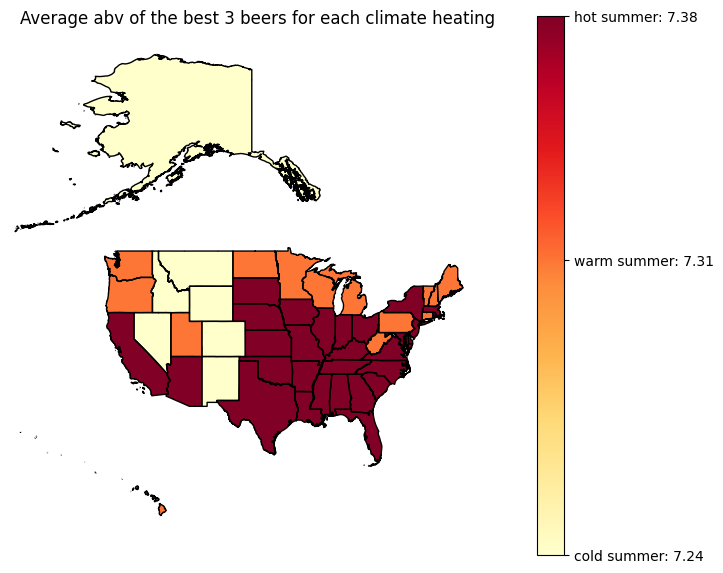

In [379]:
plot_climate_stats(
    climate_names_heating,
    "abv_mean",
    "Average abv of the best 3 beers for each climate heating",
    "climate_heating",
)

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


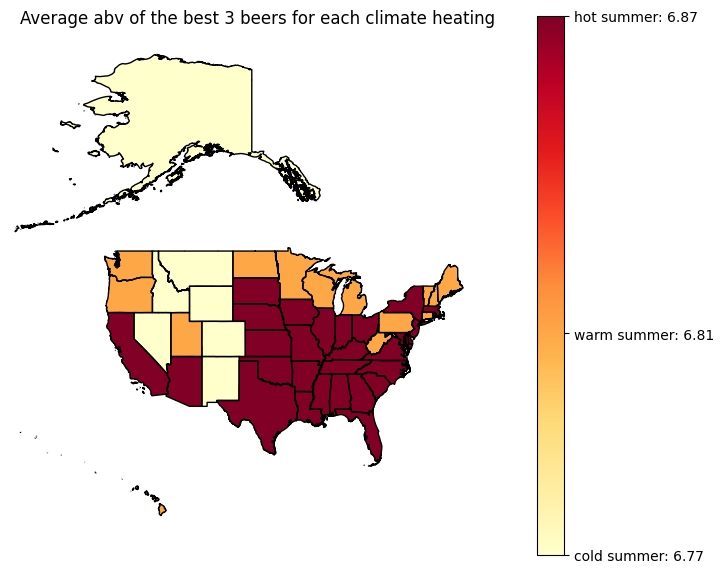

In [381]:
plot_climate_stats(
    climate_names_heating,
    "abv_mean_most_reviewd",
    "Average abv of the best 3 beers for each climate heating",
    "climate_heating",
)

/Users/emiliejemmi/miniconda3/envs/ada/lib/python3.9/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


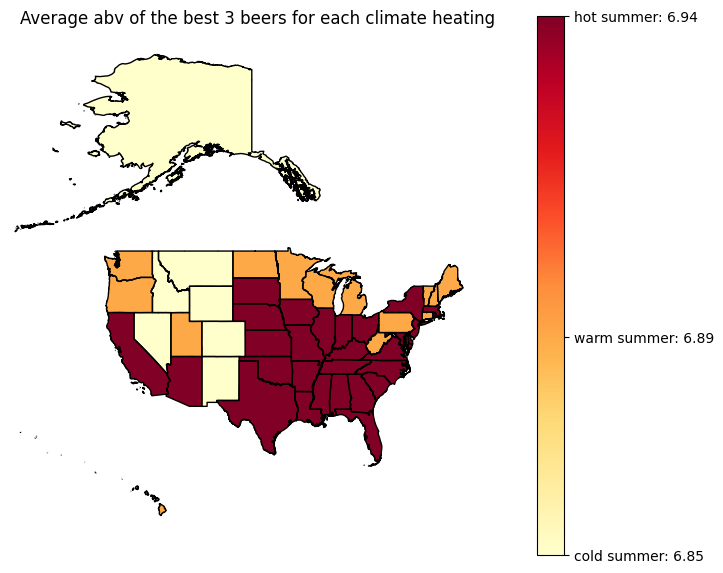

In [382]:
plot_climate_stats(
    climate_names_heating,
    "abv_mean_overall",
    "Average abv of the best 3 beers for each climate heating",
    "climate_heating",
)

In [383]:
# One-way ANOVA test for the mean abv of each climate temperature
res = stats.f_oneway(
    *[
        us_abv_ratings[us_abv_ratings.climate_temperature == zone]["abv"]
        for zone in us_abv_ratings.climate_temperature.unique()
    ],
    axis=0
)
print("One-way ANOVA test for the mean abv of each climate temperature:", res[1])

# One-way ANOVA test for the mean abv of best beers of each climate temperature
res = stats.f_oneway(
    *[
        best_beers_temperature_dfs[zone]["abv"]
        for zone in best_beers_temperature_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of best beers of each climate temperature:",
    res[1],
)

# One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature
res = stats.f_oneway(
    *[
        most_reviewed_temperature_dfs[zone]["abv"]
        for zone in most_reviewed_temperature_dfs.keys()
    ],
    axis=0
)
print(
    "One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature:",
    res[1],
)

One-way ANOVA test for the mean abv of each climate temperature: 8.852111294633652e-47
One-way ANOVA test for the mean abv of best beers of each climate temperature: 5.085188781335966e-44
One-way ANOVA test for the mean abv of most reviewed beers of each climate temperature: 4.134520396406788e-56


## 3) Correlation between ratings and abv

In [22]:
# keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("Shape before filtering:", us_users_ratings.shape)
rating_abv_df = us_users_ratings[
    (us_users_ratings["abv"] > quantile_5) & (us_users_ratings["abv"] < quantile_95)
]
print("Shape after filtering:", rating_abv_df.shape)

Shape before filtering: (862743, 36)
Shape after filtering: (754983, 36)


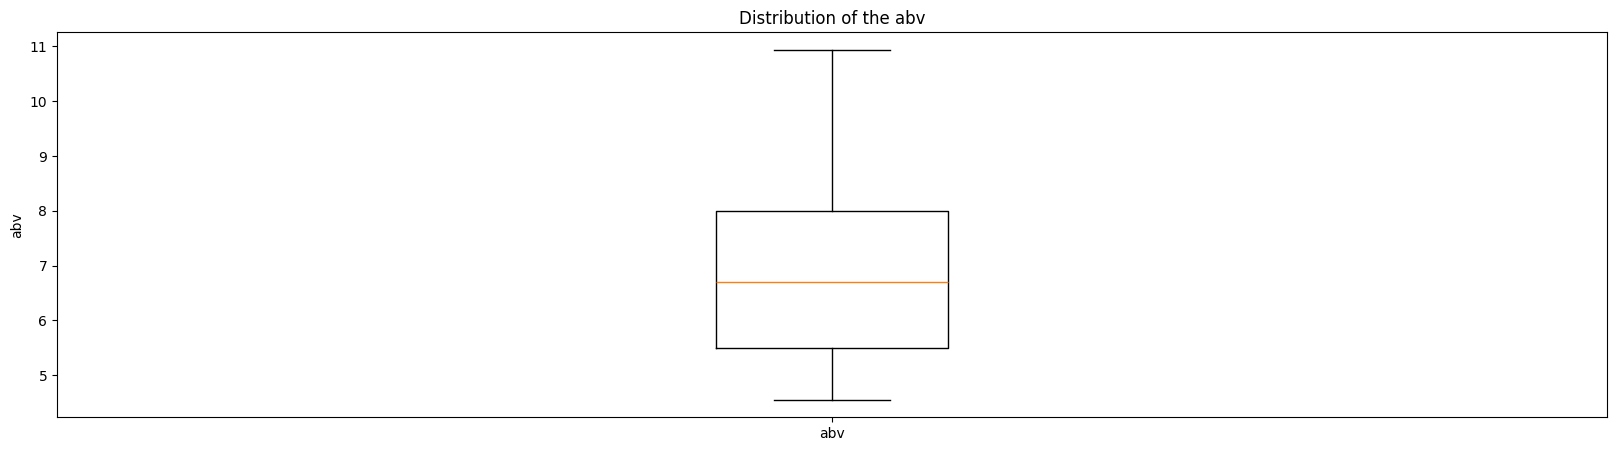

In [23]:
# Box plot of the abv
fig, ax = plt.subplots(figsize=(20, 5))
ax.boxplot(rating_abv_df["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

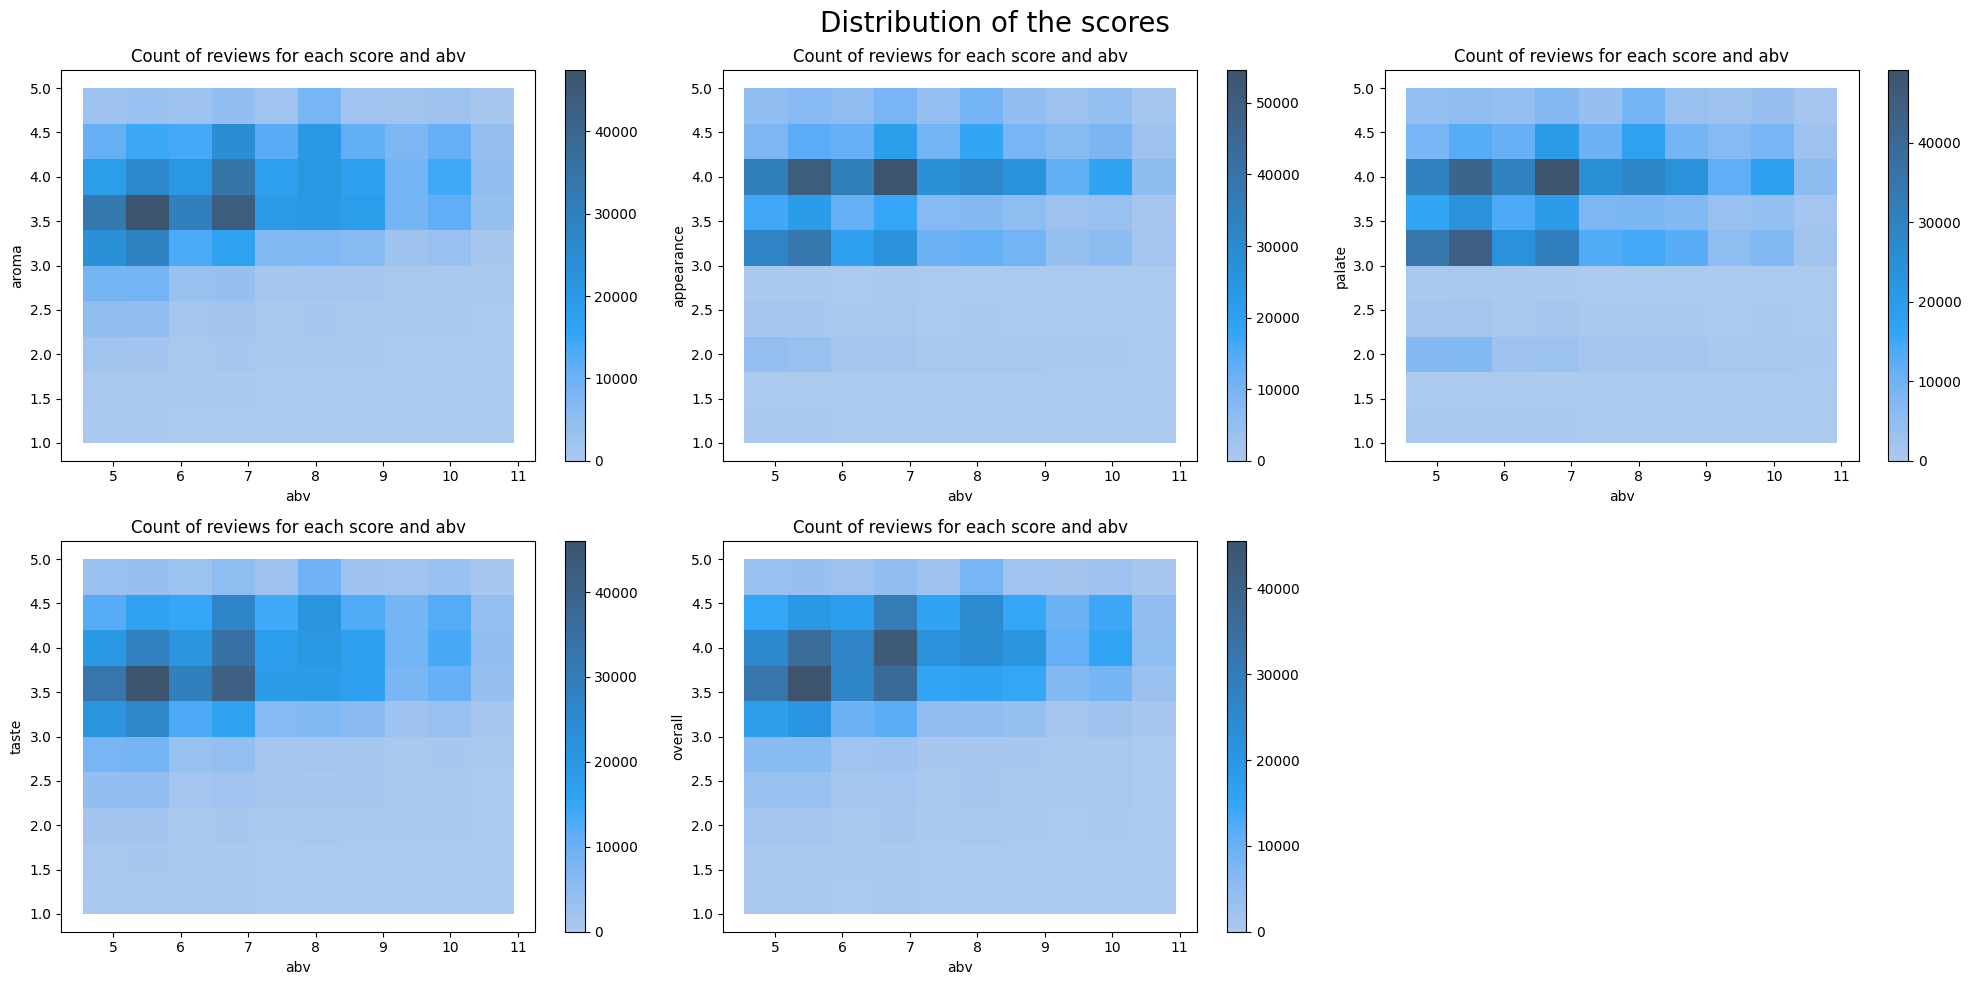

In [33]:
# 2D Histogram of the abv for each score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]

    # Heat map of the abv for each score
    sns.histplot(rating_abv_df, x="abv", y=score, bins=10, cbar=True, ax=ax)
    ax.set_title("Count of reviews for each score and abv")

axs[1][2].set_visible(False)

fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()